In [2]:
import pandas as pd
import pynbody
import numpy as np
import h5py
import pynbody.plot.sph as sph
from pynbody import units

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt




In [3]:
import sys
sys.path.append('/home/vadilloj/MAP2023/Vadillo-Justice-League-Code')
from Runnable_Modules import Base as base, IonUtils as ions, TrackingUtils as tracking


from Runnable_Modules.IonUtils import HI_factor, OVI_factor
from Runnable_Modules.Base import simulations

In [4]:
def get_CD(sim, rho, edge):
    
    """
    subsim.g sim: the gas subsim out of  which covering fraction is wabnted (particularly helpful when using filters or looking at specific halos)
    string rho: the density required,  see how HI_rho and OVI_rho are defined to add mor. Should start with desired ion
    
    sim: the .g subsim of the galaxy to use:
    rho: the string denoting the density to use, should start with the ion (eg HI or OVI) or just be 'rho' for the total
    
    edge: the edge of the central halo to use in kpc. 
    
    returns: a np.image array with a 1kpc by 1kpc resolution, in which each bin has the "column densitity" (ie number of particles n, present
    in a cm*cm square sightline at that location across the whole galaxy
    """

    nbins = 2*edge
    t_width = str(nbins) + " kpc"  #string to pass into the width parameter of pynbody .image 


    """
    key section to find the CD. The pynbody.image functionm is laid out such that if the units are set to something which can be 
    summed down the line of sight (ie a rho value, or something else with /3d area), each bin returned will have the sum of Msols enclosed in the 
    area within it.
    
    if width = resolution, as we defined above, this area will be a 1kpc by 1kpc square, enabling us to have consistent  units to ensure each bin
    contains the msol in a kpc by kpc area every time (instead of some variable, which could potentially change ie the msol in a 1/2 by 1/2 kpc bin).
    
    as such, these are set, log is set as false to allow the transform to work in the next line, and noplot = true to get the desired np format.
    """
    CD = sph.image(sim, rho, units= "Msol kpc**-2", width=t_width, log = False, resolution = nbins, noplot = True)

    #defines which of the factors to use which convert each bins value from Msol/kpc*kpc -> n_of_atoms/ cm*cm
    if rho.startswith('HI'):
        factor = HI_factor
    else:
        factor = OVI_factor


    return CD*factor

def get_detectable(CD, rho):
    """
    CD: the column density array returned by the GetCD function
    rho: the rho that it was based on (to define which threshold to use)

    returns an image array where detectable values are 1 and non detectable ones are 0
    """
    Detectable = np.copy(CD)
    
   #thresholds to define detectability, reset as needed
    HI_threshold = 10**14 #N/cm^2
    OVI_threshold = 10**13.5 #N/cm^2

    #check to use distinct values for HI and OVI
    if rho.startswith('HI'):
        Detectable[Detectable < HI_threshold] = 0
        Detectable[Detectable >= HI_threshold] = 1
    else:
        Detectable[Detectable < OVI_threshold] = 0
        Detectable[Detectable >= OVI_threshold] = 1        
        

    return Detectable;

In [37]:

def CF_Plot(data, edge,filename ):
    
    fig, axs = plt.subplots(1,2,figsize=(15,6))
    
    
    ions = ['HI', 'OVI']        
    subsects = ['total', 'local', 'halos']
    all_colors = [['royalblue', 'Navy', 'teal'], ['darkorange', 'maroon', 'orangered']]
    linestyles = ['-', '--', ':']
    for x in range(2):
        ax = axs[x]
        colors = all_colors[x]
        ion = ions[x]
        

        for y in range(3):
            subsect= subsects[y]
            radii = data[subsect][ion]['CF'][1][:-1]
            fractions = data[subsect][ion]['CF'][0]
            ax.plot(radii, fractions, label=(ion + ' ' + subsect + ' Covering Frac'), ls = linestyles[y], color=colors[y])
            
            
        ax.set_title(ion)

        ax.set_xticks(np.arange(0, 250, 25))
        ax.set_xlabel('r(kpc)')
        ax.set_ylabel('Covering Fraction')
        ax.legend()     

    
        ax.xaxis.grid(True, which='major', linestyle = "--")
        ax.set_ylim(0,1)
        ax.set_xlim(0,250)
        

    fig.suptitle(filename + ' covering fractions', fontsize = 14)

        

    plotname = "HI vs OVI Covering Fractions for " + filename +".png"
    fig.savefig(plotname)

In [10]:
def detectable_plot(data, filename):    

    ##find the places where OVI and HI are detectable regardless of what subcategory of data you are looking at (local or halos)
    
    
    bothOVI =  data['halos']['OVI']['Detectable']
    bothOVI = np.where(bothOVI == 1, data['local']['OVI']['Detectable'], 0)
    
    fig, axs = plt.subplots(1,2, figsize=(15, 6))

    
    axph = fig.add_axes(axs[0].get_position().bounds, polar=True, frameon=False, facecolor='gray')
    axpo = fig.add_axes(axs[1].get_position().bounds, polar=True, frameon=False, facecolor='gray')
    

    ions = ['HI', 'OVI']
    all_colors = [['cyan','violet', 'tab:blue'], ['red', 'orange', 'tab:orange']]
    polar_axes = [axph, axpo]
    for x in range(2):
        ion = ions[x]
        colors = all_colors[x]
        
        both =  data['halos'][ion]['Detectable']
        both = np.where(both == 1, data['local'][ion]['Detectable'], 0)
        
        
        axs[x].imshow(data['total'][ion]['Detectable'], cmap = 'bone_r', label='Both Needed', origin = 'lower')
        
        axs[x].contour(data['local'][ion]['Detectable'], colors = colors[0], levels=[0.1, 2], zorder=1, origin = 'lower')
        axs[x].contour(data['halos'][ion]['Detectable'], colors = colors[1], levels=[0.1, 2], zorder=1, origin = 'lower') 
        axs[x].contourf(both, colors =colors[2],levels=[0.1, 2], zorder=2, origin = 'lower')
    
    
        legend_elements =  [Patch(facecolor=colors[2], edgecolor=colors[2],label='Always Detectable'),
                            Patch(facecolor='black', edgecolor='black',label='Both Needed'),
                            Line2D([0], [0], color= colors[0], lw=2, label='Exclusivley Local'),
                            Line2D([0], [0],  color= colors[1], lw = 2, label='Exclusivley Halos')]
    
        polar_axes[x].legend(handles=legend_elements, loc = 'lower left', fontsize = 10)
        polar_axes[x].set_title("Detectable " + ion, fontsize = 14, y=1.05)#label the plots 
        axs[x].set_axis_off()

    plt.show()
    
    plotname = "locations of detectable HI vs OVI  for " + filename +".png"
    fig.savefig(plotname)

In [14]:

def comparison_plot(data, edge,h1, filename):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))# define plot  
        
    X = np.linspace(-edge, edge, num = data['total']['HI']['CD'][1].size)
        
        # plt1 = axs[0].imshow(OgHI, cmap = 'viridis', norm = 'log')
        # plt2 = axs[1].imshow(OgOVI, cmap = 'magma', norm = 'log')
    sph.image(h1.g, 'OVI_mass', cmap = "viridis", axes = ax[1], width = 2*edge, weight = True)
    sph.image(h1.g, 'HI_mass', cmap = "viridis", axes = ax[0], width = 2*edge, weight = True)
    plt1 = ax[0].contour(X, X, np.log10(data['total']['HI']['CD']),linewidths= 2, cmap = 'magma',levels = [12,12.5, 13,13.5,14])
    plt2 = ax[1].contour(X, X, np.log10(data['total']['OVI']['CD']),linewidths= 2, cmap = 'magma',levels = [12,12.5, 13,13.5,14])
        
        # plt1 = axs[0].contourf(X, X, np.log10(OgHI),linewidths= 1, cmap = 'magma', levels = [12,12.5,13,13.5,14],alpha = 0.25)
        # plt2 = axs[1].contourf(X, X, np.log10(OgOVI),linewidths= 1, cmap = 'viridis', levels = [12,12.5, 13,13.5,14],alpha = 0.25)
    # , 'vmin': 10e12/HI_factor,'vmax': 10e14/OVI_factor
    # plots = [plt1, plt2]
    # for row in range(2):
    #         fig.colorbar(plots[row])
    
    plt.tight_layout()
    cax = fig.add_axes([ax[1].get_position().x1+0.1,ax[1].get_position().y0,0.02,ax[0].get_position().y1-ax[1].get_position().y0])
    fig.colorbar(plt1, cax=cax)
    plt.show()
        
        
    plotname = "variance with detectability thresholds for " + filename +".png"
    fig.savefig(plotname)

In [8]:
def datatableCD(h1, Halo_Particles, edge):
    columns = ['total', 'local', 'halos']
    rows = ['HI', 'OVI']
    datatable  = {}
    for source in columns:
        Sources = {}
        for ion in rows:
            rho = ion + '_rho'
            if source  == 'total':
                sim = h1.g
            else:
                sim = Halo_Particles[source]
                
                
                
            cd = get_CD(sim, rho, edge)
            detectable = get_detectable(cd, rho)
            CF = base.Polar_Profile(detectable, edge)
            data = pd.Series({"CD": cd,
                                "Detectable": detectable, 
                                "CF": CF})
            Sources[ion]  = data
        datatable[source] = Sources
        
    return pd.DataFrame(datatable)
            
            

In [ ]:
filenames = ['Elena','Sandra', 'Sonia', 'Ruth']
tracking.find_halo_keys(simulations)
data_filepath = '/home/vadilloj/MAP2023/Vadillo-Justice-League-Code/Covering Fractions -c/Data'
for filename in filenames:
    s, h1 = base.load_in_sim(filename)
    ions.calculate_gas_mass(s)
    ions.calculate_gas_rhos(s)

    Halo_Particles = tracking.find_halo_particles(h1, simulations, filename)

    Halo_frac  = (np.sum(Halo_Particles['halos'].g['mass'])/np.sum(h1.g['mass']))*100
    print (str(Halo_frac) +" percent of mass is from sattelites in " + filename)

    HI_Halo_frac  = (np.sum(Halo_Particles['halos'].g['HI_mass'])/np.sum(h1.g['HI_mass']))*100
    print (str(HI_Halo_frac) +" percent of HI is from sattelites in " + filename)

    OVI_Halo_frac  = (np.sum(Halo_Particles['halos'].g['OVI_mass'])/np.sum(h1.g['OVI_mass']))*100
    print (str(OVI_Halo_frac) +" percent of OVI is from sattelites in " + filename)
    
    
    edge = int(np.max(h1.g['r']))
    dataCF = datatableCD(h1, Halo_Particles, edge)
    datafileName = filename + ' CF data.csv'
    
    dataCF.to_csv(datafileName)
    
    CF_Plot(dataCF, edge, filename)
    detectable_plot(dataCF,filename)
    comparison_plot(dataCF, edge, h1, filename)
    

    


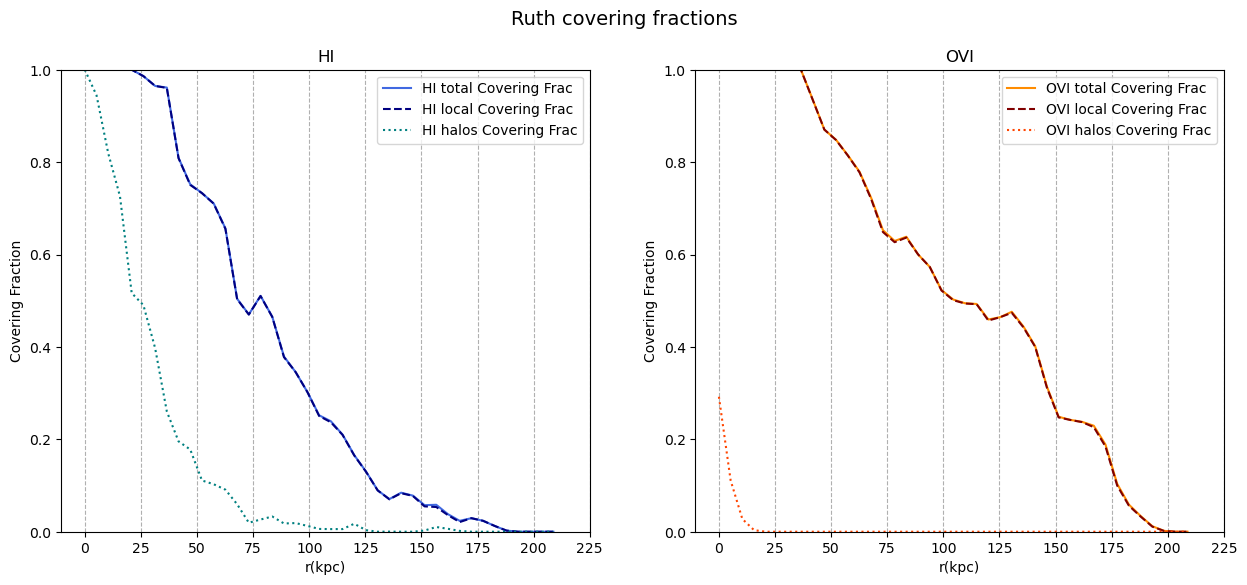

In [36]:
CF_Plot(dataCF, edge, filename)

In [77]:
HI_CD = get_CD(h1.g, "HI_rho", edge)
HI_CF = (base.Polar_Profile(HI_CD, edge))

,total,local,halos
HI,"CD [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CD [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CD [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
OVI,"CD [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CD [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","CD [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
HI_CF_2 = dataCF['total']['HI']['CF']

In [21]:
np.max(HI_CF_2[0])

np.float64(1.0)

In [80]:
np.max(HI_CF)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

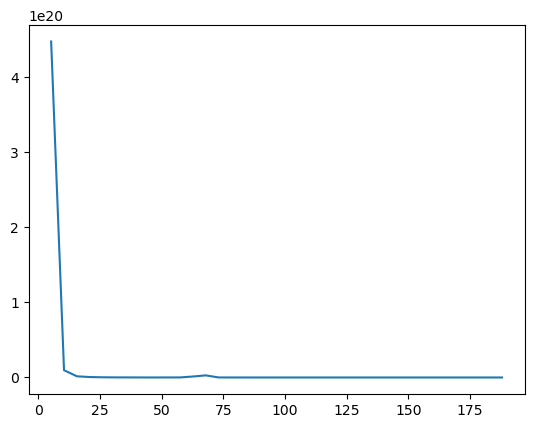

In [79]:
plt.plot(HI_CF[1][1:], HI_CF[0])

In [ ]:
HI_